In [49]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns


In [50]:
# Data Loading and Preprocessing
file_path = 'API_6_DS2_en_csv_v2_15115.csv'
data = pd.read_csv(file_path, header=2)
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,"Mortality rate attributed to unsafe water, uns...",SH.STA.WASH.P5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,ABW,People using safely managed sanitation service...,SH.STA.SMSS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aruba,ABW,People using safely managed sanitation service...,SH.STA.SMSS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,People using safely managed sanitation service...,SH.STA.SMSS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,Mortality rate attributed to unintentional poi...,SH.STA.POIS.P5.MA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Melt and filter relevant indicators
data_clean = data.drop(columns=['Unnamed: 68'], errors='ignore')
data_melted = data_clean.melt(id_vars=['Country Name', 'Indicator Name'], var_name='Year', value_name='Value')

indicators_selected = [
    'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Forest area (% of land area)'
]
data_selected = data_melted[data_melted['Indicator Name'].isin(indicators_selected)]


In [52]:
# Pivot and clean the data
data_pivot = data_selected.pivot_table(index=['Country Name', 'Year'], columns='Indicator Name', values='Value', aggfunc='first')
data_filtered = data_pivot.reset_index()

In [53]:
# Convert columns to numeric and handle missing values
data_filtered['PM2.5 Air Pollution'] = pd.to_numeric(data_filtered['PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)'], errors='coerce')
data_filtered['Forest Area'] = pd.to_numeric(data_filtered['Forest area (% of land area)'], errors='coerce')
data_filtered['Renewable Energy'] = pd.to_numeric(data_filtered['Renewable energy consumption (% of total final energy consumption)'], errors='coerce')


In [54]:
# Impute missing values with column means
data_filtered['PM2.5 Air Pollution'].fillna(data_filtered['PM2.5 Air Pollution'].mean(), inplace=True)
data_filtered['Forest Area'].fillna(data_filtered['Forest Area'].mean(), inplace=True)
data_filtered['Renewable Energy'].fillna(data_filtered['Renewable Energy'].mean(), inplace=True)


<ipython-input-54-dc4eb3a3871b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filtered['PM2.5 Air Pollution'].fillna(data_filtered['PM2.5 Air Pollution'].mean(), inplace=True)
<ipython-input-54-dc4eb3a3871b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [55]:
# Prepare clustering data
clustering_data_clean = data_filtered[['Forest Area', 'PM2.5 Air Pollution', 'Renewable Energy']]


In [56]:
# Normalize the data
scaler = StandardScaler()
data_scaled_clean = scaler.fit_transform(clustering_data_clean)


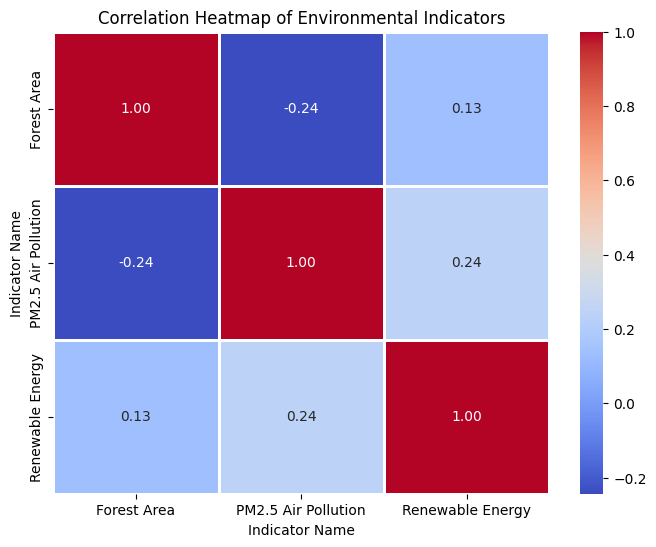

In [63]:
def plot_correlation_heatmap(data_filtered):
    """
    Plot a heatmap showing correlations among selected features.

    Args:
        data_filtered (pd.DataFrame): Dataset with numeric features.
    """
    corr_matrix = data_filtered[['Forest Area', 'PM2.5 Air Pollution', 'Renewable Energy']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
    plt.title('Correlation Heatmap of Environmental Indicators')
    plt.show()

plot_correlation_heatmap(data_with_clusters)

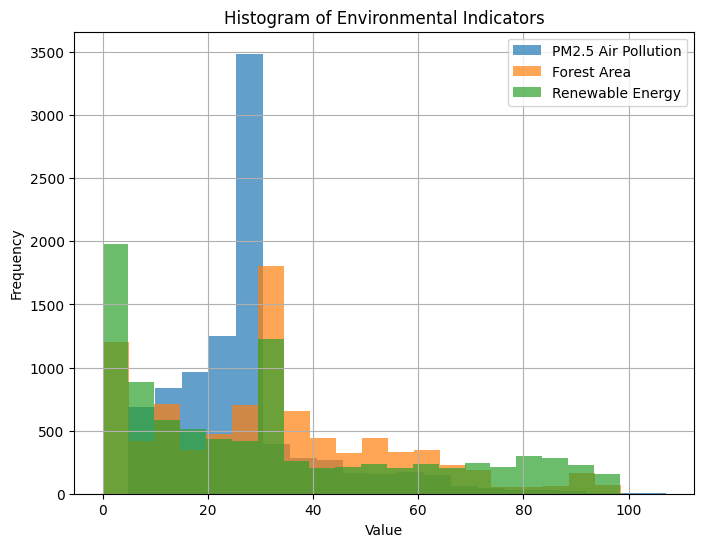

In [62]:
def plot_histogram(data_filtered):
    """
    Plot histograms for selected features.

    Args:
        data_filtered (pd.DataFrame): Dataset with numeric features.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(data_filtered['PM2.5 Air Pollution'], bins=20, alpha=0.7, label='PM2.5 Air Pollution')
    plt.hist(data_filtered['Forest Area'], bins=20, alpha=0.7, label='Forest Area')
    plt.hist(data_filtered['Renewable Energy'], bins=20, alpha=0.7, label='Renewable Energy')
    plt.title('Histogram of Environmental Indicators')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram(data_with_clusters)

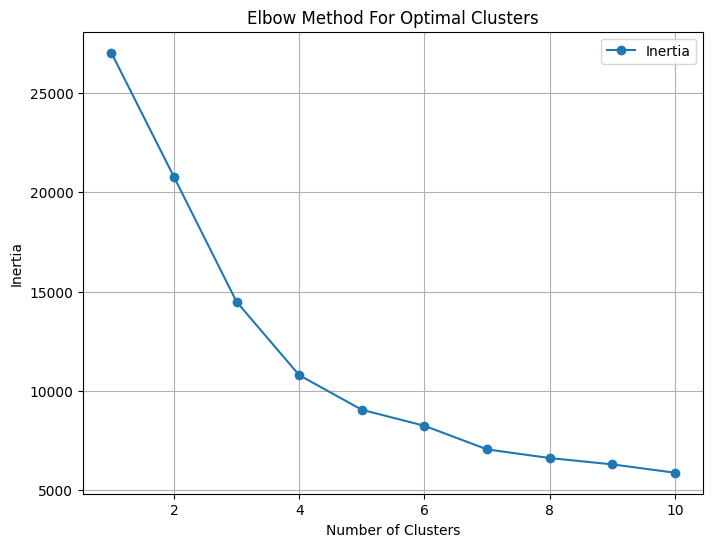

In [71]:
def plot_elbow_method(data_scaled):
    """
    Plot the elbow method to determine the optimal number of clusters.

    Args:
        data_scaled (numpy.ndarray): Scaled data for clustering.
    """
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), inertia, marker='o', label='Inertia')
    plt.title('Elbow Method For Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
plot_elbow_method(data_scaled_clean)


In [58]:
# Functions for analysis and visualization
def perform_kmeans(data_scaled, data_filtered, n_clusters=3):
    """
    Perform KMeans clustering and add cluster labels to the dataset.

    Args:
        data_scaled (numpy.ndarray): Scaled data for clustering.
        data_filtered (pd.DataFrame): Original filtered dataset.
        n_clusters (int): Number of clusters.

    Returns:
        tuple: KMeans model and updated dataset with cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data_filtered['Cluster'] = kmeans.fit_predict(data_scaled)
    return kmeans, data_filtered

kmeans_model, data_with_clusters = perform_kmeans(data_scaled_clean, data_filtered, n_clusters=3)

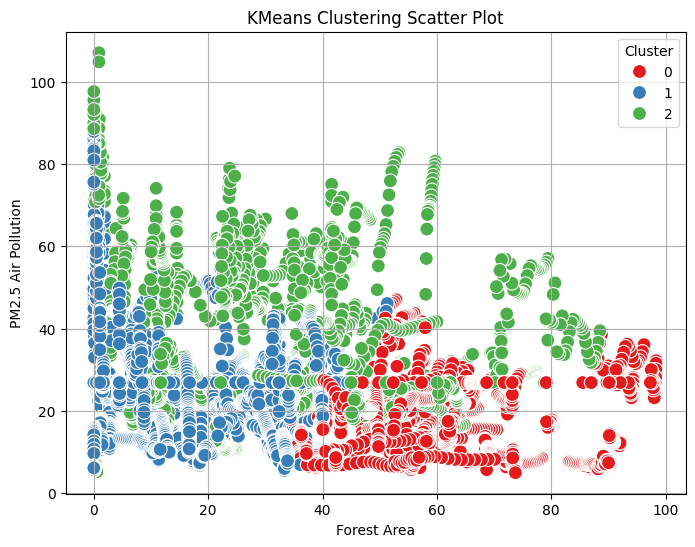

In [59]:
def plot_kmeans_scatter(data_filtered):
    """
    Plot scatter plot for KMeans clustering results.

    Args:
        data_filtered (pd.DataFrame): Dataset with cluster labels.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='Forest Area',
        y='PM2.5 Air Pollution',
        hue='Cluster',
        palette='Set1',
        data=data_filtered,
        s=100
    )
    plt.title('KMeans Clustering Scatter Plot')
    plt.xlabel('Forest Area')
    plt.ylabel('PM2.5 Air Pollution')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

plot_kmeans_scatter(data_with_clusters)


<Figure size 800x600 with 0 Axes>

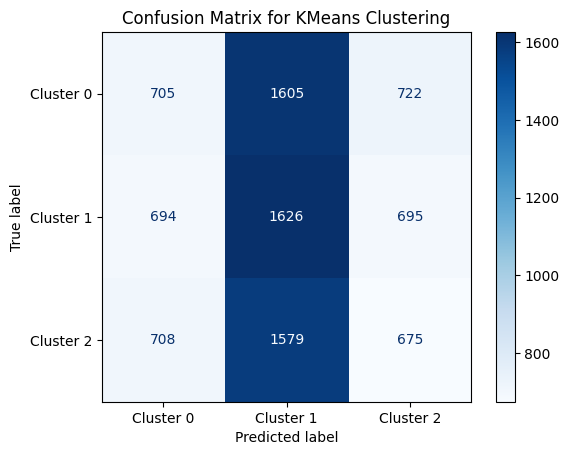

In [60]:
def plot_confusion_matrix(data_filtered):
    """
    Plot the confusion matrix for KMeans clustering.

    Args:
        data_filtered (pd.DataFrame): Dataset with cluster labels.
    """
    # Simulate "true labels" for demonstration
    np.random.seed(42)
    true_labels = np.random.randint(0, 3, len(data_filtered))  # Replace with actual true labels if available

    predicted_labels = data_filtered['Cluster']
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f'Cluster {i}' for i in range(3)])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix for KMeans Clustering')
    plt.show()

plot_confusion_matrix(data_with_clusters)

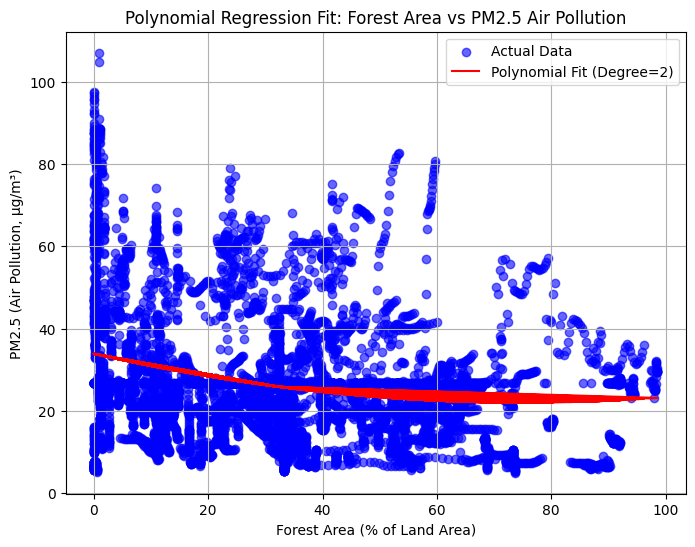

In [69]:
def plot_polynomial_fit_forest_vs_air(data_filtered, degree=2):
    """
    Plot the polynomial regression fit for Forest Area vs. PM2.5.

    Args:
        data_filtered (pd.DataFrame): Dataset with numeric features.
        degree (int): Degree of the polynomial used for regression.
    """
    # Extract relevant features
    X = data_filtered[['Forest Area']]
    y = data_filtered['PM2.5 Air Pollution']

    # Polynomial feature expansion
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Fit the model
    regressor = LinearRegression()
    regressor.fit(X_poly, y)

    # Generate predictions
    y_pred = regressor.predict(X_poly)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(data_filtered['Forest Area'], data_filtered['PM2.5 Air Pollution'], color='blue', alpha=0.6, label='Actual Data')
    plt.plot(data_filtered['Forest Area'], y_pred, color='red', label=f'Polynomial Fit (Degree={degree})')
    plt.title('Polynomial Regression Fit: Forest Area vs PM2.5 Air Pollution')
    plt.xlabel('Forest Area (% of Land Area)')
    plt.ylabel('PM2.5 (Air Pollution, µg/m³)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Polynomial Fit Plot: Forest Area vs PM2.5
plot_polynomial_fit_forest_vs_air(data_with_clusters, degree=2)
